In [82]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../modules')
from seeDistinctValues import seeDistinctValues
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, precision_recall_fscore_support, confusion_matrix, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from collections import Counter

df = pd.read_csv('merged_checked.csv')

In [83]:
df

,Unnamed: 0.1,Unnamed: 0,id,title,annotator,Q1.1,Q1.2,Q1.3,Q1.3.1,Q1.4,Q1.5,Q1.6,Q1.7,Q1.7.1,Q1.7.1.2
0,0,0,18d71db7-f362-46fa-953e-d8353c7f7232,Coronavirus| nuove regole: al tavolo al ristor...,Manuel,2;1;1;1;1,2,3,-1,2,4,4,1,-1,-1
1,1,1,18d71db7-f362-46fa-953e-d8353c7f7232,Coronavirus| nuove regole: al tavolo al ristor...,Angelo,2;1;1;1;1,3,1;3,1,1,4,4,1,-1,-1
2,2,2,3ca70f03-38f3-4a7b-bdd3-f012b22e0c7e,Israele: Lapid| ostacoli ma fiducioso su nuovo...,Manuel,2;1;1;1;1,4,1;3,-1,2,4,4,1,-1,-1
3,3,3,3ca70f03-38f3-4a7b-bdd3-f012b22e0c7e,Israele: Lapid| ostacoli ma fiducioso su nuovo...,Marinella,2;1;1;1;1,4,1;3,-1,1,4,4,2,-1,-1
4,4,4,34b92f4c-32db-454c-a369-ca2032443f6c,Le borsette fatte a 3 euro l'ora vendute a 820...,Manuel,1;2;1;1;1,3,3,-1,1,3,2,2,-1,Fashion craft industries system
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,1014,1014,3696bc79-2f24-47e2-9f13-fabd92b7a271,"Variante Delta, quanto sono efficaci i vaccini...",ChatGPT4AsAnnotator,2;1;2;1;1,4,1;3,-1,2,4,4,1,6,-1
1015,1015,1015,89ca8966-8ade-49fd-a036-c528a1f7871c,Tutti i passi falsi di Davigo: dal caso Palama...,ChatGPT4AsAnnotator,1;1;2;1;1,4,1;3,-1,2,4,4,2,6,-1
1016,1016,1016,a425710b-96e3-4840-87be-75deea62775d,Quanto si preoccupa l'Ue per la Macron fatigue,ChatGPT4AsAnnotator,2;1;2;1;1,4,1;3;5,-1,1,4,4,1,6,-1
1017,1017,1017,df86ebbe-1672-4c99-8895-b0fe742ed00c,CSM ED I VERBALI DI AMARA: I SEGRETI DELLA NUO...,ChatGPT4AsAnnotator,1;2;2;1;1,4,1;2,-1,1,3,3,2,6,"Judiciary, media professionals"


# Funzioni

## Funzione classica per il calcolo del Kappa


In [84]:
def inter_annotator_agreement(df, column_name, annotator1, annotator2, optional, numerical = False):
    r"""
    The inter_annotator_agreement function calculates the inter-annotator agreement between 
    two annotators for a given column in a DataFrame using Cohen's kappa score.
    Parameters:
        df: The DataFrame containing the annotation data.
        column_name: The name of the column for which the agreement is being calculated.
        annotator1: The name of the first annotator.
        annotator2: The name of the second annotator.
        optional: A boolean indicating whether missing values (or specific placeholder values) should be excluded from the analysis.
        numerical: A boolean indicating whether the column contains numerical values.

    """
    # Filter rows for the given annotators
    df_annotator1 = df[df['annotator'] == annotator1]
    df_annotator2 = df[df['annotator'] == annotator2]
    
    # Merge dataframes on the ID column
    merged_df = df_annotator1.merge(df_annotator2, on='id')
    
    # Filter rows with non-missing values for the given column
    merged_df = merged_df.dropna(subset=[column_name+'_x', column_name+'_y'])

    # Rimuovo le righe vuote dal dataset degli annotatori
    if (not optional):
        merged_df = merged_df[merged_df[column_name+'_x'] != -1]
        merged_df = merged_df[merged_df[column_name+'_x'] != '-1']
        merged_df = merged_df[merged_df[column_name+'_y'] != -1]
        merged_df = merged_df[merged_df[column_name+'_y'] != '-1']
    
    if (numerical):
        agreement_score = cohen_kappa_score(merged_df[column_name+'_x'], merged_df[column_name+'_y'])
    else:
        # Converto le colonne in stringhe
        merged_df[column_name + '_x'] = merged_df[column_name + '_x'].astype(str)
        merged_df[column_name + '_y'] = merged_df[column_name + '_y'].astype(str)
        agreement_score = cohen_kappa_score(merged_df[column_name+'_x'], merged_df[column_name+'_y'])

    print('Kappa tra ' + annotator1 + ' e ' + annotator2 + ' per ' + column_name + ': ' + str(agreement_score))


## Funzione per le metriche standard (balanced accuracy)

In [85]:
def calculate_standard_metrics(annotator_1, annotator_2, df, optional=False):
    filtered_df = df[df['annotator'].isin([annotator_1, annotator_2])]
    ids_annotator_1 = filtered_df[filtered_df['annotator'] == annotator_1]['id']
    ids_annotator_2 = filtered_df[filtered_df['annotator'] == annotator_2]['id']
    common_ids = ids_annotator_1[ids_annotator_1.isin(ids_annotator_2)]
    df = filtered_df[filtered_df['id'].isin(common_ids)]

    gpt_df = df[df['annotator'] == annotator_2]
    human_df = df[df['annotator'] == annotator_1]

    results = {}

    merged_data = pd.merge(gpt_df, human_df, on="id", suffixes=("_gpt", "_human"))

    columns_of_interest = df.drop(columns=['id', 'annotator']).columns.tolist()

    plt.subplots_adjust(top=10)

    for col in columns_of_interest:
        y_gpt = merged_data[col + "_gpt"]
        y_human = merged_data[col + "_human"]

        if not optional:
            # Filter out cases where either annotator has value -1
            valid_indices = (y_gpt != -1) & (y_gpt != '-1') & (y_human != -1) & (y_human != '-1')
        else:
            valid_indices = pd.Series([True] * len(y_gpt))
        
        y_gpt = y_gpt[valid_indices]
        y_human = y_human[valid_indices]

        if len(y_gpt) == 0:
            continue  # Skip this column if there are no valid annotations
        
        # Baseline "most_frequent" (as you already have)
        baseline_model_most_frequent = DummyClassifier(strategy="most_frequent")
        # Filtering human_df based on the IDs present in merged_data with valid indices
        baseline_model_most_frequent.fit(human_df.loc[human_df['id'].isin(merged_data.loc[valid_indices, 'id']), [col]], y_human)
        y_pred_baseline_most_frequent = baseline_model_most_frequent.predict(human_df.loc[human_df['id'].isin(merged_data.loc[valid_indices, 'id']), [col]])

        # Baseline "stratified"
        baseline_model_stratified = DummyClassifier(strategy="stratified")
        # Same filtering for stratified baseline model
        baseline_model_stratified.fit(human_df.loc[human_df['id'].isin(merged_data.loc[valid_indices, 'id']), [col]], y_human)
        y_pred_baseline_stratified = baseline_model_stratified.predict(human_df.loc[human_df['id'].isin(merged_data.loc[valid_indices, 'id']), [col]])

        balanced_acc = balanced_accuracy_score(y_human, y_gpt)
        f1_micro = f1_score(y_human, y_gpt, average='micro')
        f1_macro = f1_score(y_human, y_gpt, average='macro')
        f1_avg = f1_score(y_human, y_gpt, average='weighted')

        balanced_acc_baseline_most_frequent = balanced_accuracy_score(y_human, y_pred_baseline_most_frequent)
        f1_micro_baseline_most_frequent = f1_score(y_human, y_pred_baseline_most_frequent, average='micro')
        f1_macro_baseline_most_frequent = f1_score(y_human, y_pred_baseline_most_frequent, average='macro')
        f1_avg_baseline_most_frequent = f1_score(y_human, y_pred_baseline_most_frequent, average='weighted')

        balanced_acc_baseline_stratified = balanced_accuracy_score(y_human, y_pred_baseline_stratified)
        f1_micro_baseline_stratified = f1_score(y_human, y_pred_baseline_stratified, average='micro')
        f1_macro_baseline_stratified = f1_score(y_human, y_pred_baseline_stratified, average='macro')
        f1_avg_baseline_stratified = f1_score(y_human, y_pred_baseline_stratified, average='weighted')

        results[col] = {
            'balanced_accuracy': balanced_acc,
            'f1_micro': f1_micro,
            'f1_macro': f1_macro,
            'f1_avg': f1_avg,
            'baseline_most_frequent_balanced_accuracy': balanced_acc_baseline_most_frequent,
            'baseline_most_frequent_f1_micro': f1_micro_baseline_most_frequent,
            'baseline_most_frequent_f1_macro': f1_macro_baseline_most_frequent,
            'baseline_most_frequent_f1_avg': f1_avg_baseline_most_frequent,
            'baseline_stratified_balanced_accuracy': balanced_acc_baseline_stratified,
            'baseline_stratified_f1_micro': f1_micro_baseline_stratified,
            'baseline_stratified_f1_macro': f1_macro_baseline_stratified,
            'baseline_stratified_f1_avg': f1_avg_baseline_stratified
        }
    num_cols = len(columns_of_interest)
    num_plots_per_row = 3
    num_rows = (num_cols + num_plots_per_row - 1) // num_plots_per_row

    fig, axs = plt.subplots(num_rows, num_plots_per_row, figsize=(18, 4*num_rows))

    for i, col in enumerate(columns_of_interest):
        metrics = results[col]

        labels = ['Bal. Accuracy', 'F1 Micro', 'F1 Macro', 'F1 Weighted']
        model_values = [metrics['balanced_accuracy'], metrics['f1_micro'], metrics['f1_macro'], metrics['f1_avg']]
        baseline_values_most_frequent = [metrics['baseline_most_frequent_balanced_accuracy'], metrics['baseline_most_frequent_f1_micro'],
                                         metrics['baseline_most_frequent_f1_macro'], metrics['baseline_most_frequent_f1_avg']]
        baseline_values_stratified = [metrics['baseline_stratified_balanced_accuracy'], metrics['baseline_stratified_f1_micro'],
                                      metrics['baseline_stratified_f1_macro'], metrics['baseline_stratified_f1_avg']]

        row_idx = i // num_plots_per_row
        col_idx = i % num_plots_per_row

        x = np.arange(len(labels))
        width = 0.25

        axs[row_idx, col_idx].bar(x - width, model_values, width, label='Model')
        axs[row_idx, col_idx].bar(x, baseline_values_most_frequent, width, label='Baseline (most frequent)')
        axs[row_idx, col_idx].bar(x + width, baseline_values_stratified, width, label='Baseline (stratified)')

        for j, (v, b1, b2) in enumerate(zip(model_values, baseline_values_most_frequent, baseline_values_stratified)):
            offset = 0
            axs[row_idx, col_idx].text(x[j] - width + offset, v + 0.01, f"{v:.4f}", ha='center', fontsize=7)
            axs[row_idx, col_idx].text(x[j], b1 + 0.01, f"{b1:.4f}", ha='center', fontsize=7)
            axs[row_idx, col_idx].text(x[j] + width + offset, b2 + 0.01, f"{b2:.4f}", ha='center', fontsize=7)

        axs[row_idx, col_idx].set_ylabel('Score')
        axs[row_idx, col_idx].set_title(f'Metrics for {col}')
        axs[row_idx, col_idx].set_xticks(x)
        axs[row_idx, col_idx].set_xticklabels(labels)
        axs[row_idx, col_idx].legend()
        axs[row_idx, col_idx].set_ylim(0, 1.07)

    for i in range(num_rows * num_plots_per_row):
        if i >= num_cols:
            axs.flatten()[i].axis('off')

    plt.tight_layout()
    plt.show()

## Confusion Matrix

In [86]:
def calculate_confusion_matrix(annotator_1, annotator_2, columns, possible_values):
    confusion_matrices = {}
    for column in columns:
        y_true = []
        y_pred = []

        articles = set(df[df['annotator'] == annotator_1]['id']).intersection(
            set(df[df['annotator'] == annotator_2]['id']))

        for article_id in articles:
            annotator1 = df[(df['id'] == article_id) & (df['annotator'] == annotator_1)][[column]]
            annotator2 = df[(df['id'] == article_id) & (df['annotator'] == annotator_2)][[column]]

            annotator1 = annotator1.astype(str)
            annotator2 = annotator2.astype(str)

            for col in annotator1.columns:
                annotations_1 = annotator1[col].values.flatten()
                annotations_2 = annotator2[col].values.flatten()
                for ann_1, ann_2 in zip(annotations_1, annotations_2):
                    y_true.append(ann_1)
                    y_pred.append(ann_2)

        confusion_matrices[column] = confusion_matrix(y_true, y_pred, labels=possible_values[column])
    plot_confusion_matrices(confusion_matrices, possible_values)
    return 0

def plot_confusion_matrices(conf_matrices, possible_values):
    num_cols = len(conf_matrices)
    num_rows = int(np.ceil(num_cols / 4))
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 4))

    # If there's only one row, axes may not be a 2D array
    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    
    for i, (column, conf_matrix) in enumerate(conf_matrices.items()):
        row = i // 4
        col = i % 4
        sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[row, col], 
                    xticklabels=possible_values[column], yticklabels=possible_values[column])
        axes[row, col].set_xlabel("Predicted labels")
        axes[row, col].set_ylabel("True labels")
        axes[row, col].set_title(f"Confusion Matrix for Column '{column}'")

    # Hide any unused subplots
    for j in range(i + 1, num_rows * 4):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

columns_to_consider = ["Q1.2", "Q1.3.1", "Q1.4", "Q1.5", "Q1.6", "Q1.7"]
possible_values = {
    'Q1.2': ['1', '2', '3', '4'],
    'Q1.3.1': ['1', '2'],
    'Q1.4': ['1', '2'],
    'Q1.5': ['1', '2', '3', '4'],
    'Q1.6': ['1', '2', '3', '4'],
    'Q1.7': ['1', '2'],
}


# Q 1.1 

## Questions

### Original

Q1.1: What type of news article are you reviewing? (Check one): <br>
    1.  Straight news, or 'hard news' <br>
    2.  Editorial/opinion <br>
    3.  Feature/investigation <br>
    4.  Satire <br>
    5.  Lifestyle content, obituary, 'listicle', or other 'soft news' <br>


### Revisited

Step 2  - Is this article Straight news or 'hard news'?(if the article reports essential information in a concise and impartial manner,  the information should be based on facts, and there should be no personal opinion of the author)
    1.  No
    2.  Yes

Step 3 - Is this article an Editorial/opinion?(if the article communicates the author’s personal point of view about current events and topics in order to develop an argument about an issue and potentially sway readers’ opinions.​​ Opinion pieces include editorials, op-eds, commentary, analysis, and letters to the editor.)    
    1.  No
    2.  Yes

Step 4 - Is this article a Feature/investigation? (if the article contains at least one of the following elements: in-depth coverage, rich storytelling, and investigative elements)
    1.  No
    2.  Yes

Step 5 - Is this article a  Satire?
    1.  No
    2.  Yes

Step 6  - Is this article Lifestyle content, obituary, 'listicle,' or other 'soft news' or gossip? 
    1.  No
    2.  Yes



## Analisi

### K

In [87]:
opzionale = False
inter_annotator_agreement(df, 'Q1.1', 'Manuel', 'Angelo', opzionale)
inter_annotator_agreement(df, 'Q1.1', 'Manuel', 'Marinella', opzionale)
inter_annotator_agreement(df, 'Q1.1', 'Angelo', 'Marinella', opzionale)
print('----------------------------------')
inter_annotator_agreement(df, 'Q1.1', 'Manuel', 'ChatGPT4AsAnnotator', opzionale)
inter_annotator_agreement(df, 'Q1.1', 'Marinella', 'ChatGPT4AsAnnotator', opzionale)
inter_annotator_agreement(df, 'Q1.1', 'Angelo', 'ChatGPT4AsAnnotator', opzionale)


Kappa tra Manuel e Angelo per Q1.1: 0.6903472443453329
Kappa tra Manuel e Marinella per Q1.1: 0.7307060755336616
Kappa tra Angelo e Marinella per Q1.1: 0.8258518117901569
----------------------------------
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.1: 0.19536670997705474
Kappa tra Marinella e ChatGPT4AsAnnotator per Q1.1: 0.19281271596406346
Kappa tra Angelo e ChatGPT4AsAnnotator per Q1.1: 0.2234433608402101


### Vedo dove e come sbaglia

In [88]:

def custom_agreement(column_name,set1, set2):

    # Split the numbers
    set1 = set1.split(";")
    set2 = set2.split(";")

    # Verifica se entrambe le liste contengono almeno un 2
    if '2' in set1 and '2' in set2:
        # Verifica se i 2 sono nella stessa posizione
        if set1 == set2:
            return "Perfect Agreement (All correct)"
        # Verifica se nella seconda lista c'è almeno un 2 nella stessa posizione
        elif any(a == b == '2' for a, b in zip(set1, set2)):
            #print ('lista 1' +str(set1) + ' lista 2' + str(set2))
            return "Partial Agreement (Extra Incorrect)"
        else:
            return "No Agreement (All Incorrect)"
    else:
        return "No Agreement (All Incorrect)"


def discoverValues(df, column_name, annotator1, annotator2):
    # Creo l'oggetto per contare le divergenze
    divergences = Counter()

    df_annotator1 = df[df['annotator'] == annotator1]
    df_annotator2 = df[df['annotator'] == annotator2]
    
    merged_df = df_annotator1.merge(df_annotator2, on='id')
    merged_df = merged_df.dropna(subset=[column_name+'_x', column_name+'_y'])
    
    perfect_agreement_count = 0
    partial_correct_count = 0

    partial_extra_count = 0
    no_agreement_count = 0
    
    for index, row in merged_df.iterrows():
        if (row[column_name+'_x'] != -1 and row[column_name+'_x'] != '-1'):
            agreement_category = custom_agreement(column_name,row[column_name+'_x'], row[column_name+'_y'])
            if agreement_category == 'Perfect Agreement (All correct)':
                perfect_agreement_count += 1
            elif agreement_category == 'Partial Agreement (Some Correct)':
                partial_correct_count += 1
            elif agreement_category == 'Partial Agreement (Extra Incorrect)':
                partial_extra_count += 1
            elif agreement_category == 'No Agreement (All Incorrect)':
                no_agreement_count += 1

    print(annotator1 + ' e ' + annotator2 + ' per ' + column_name + ':')

    print('   Perfect Agreement:', perfect_agreement_count)
    if (column_name != 'Q1.1'):
        print('   Partial Agreement (Some Correct):', partial_correct_count)
    print('   Partial Agreement (Extra Incorrect):', partial_extra_count)
    print('   No Agreement (All Incorrect):', no_agreement_count)
    print('\n')


discoverValues(df, 'Q1.1', 'Manuel', 'ChatGPT4AsAnnotator')

Manuel e ChatGPT4AsAnnotator per Q1.1:
   Perfect Agreement: 105
   Partial Agreement (Extra Incorrect): 76
   No Agreement (All Incorrect): 50




### Cerco pattern di errori comuni

In [89]:
def discoverValues(df, column_name, annotator1, annotator2):
    # Creo l'oggetto per contare le divergenze
    divergences = Counter()

    df_annotator1 = df[df['annotator'] == annotator1]
    df_annotator2 = df[df['annotator'] == annotator2]
    
    merged_df = df_annotator1.merge(df_annotator2, on='id')
    merged_df = merged_df.dropna(subset=[column_name+'_x', column_name+'_y'])
    
    for index, row in merged_df.iterrows():
        if (row[column_name+'_x'] != -1 and row[column_name+'_x'] != '-1'):
            agreement_category = custom_agreement(column_name, row[column_name+'_x'], row[column_name+'_y'])
            if agreement_category == 'Partial Agreement (Extra Incorrect)':
                divergences[(tuple(row[column_name+'_x'].split(';')), tuple(row[column_name+'_y'].split(';')))] += 1

    # Ritorna i primi 10 casi più frequenti di divergenza
    return divergences.most_common(10)

# Modifica il chiamato di discoverValues per salvarne i risultati
divergences = discoverValues(df, 'Q1.1', 'Manuel', 'ChatGPT4AsAnnotator')
print("Casi più frequenti di divergenza tra la prima e la seconda lista:")
for divergence, count in divergences:
    print("Divergenza:", divergence, " - Frequenza:", count)

Casi più frequenti di divergenza tra la prima e la seconda lista:
Divergenza: (('2', '1', '1', '1', '1'), ('2', '1', '2', '1', '1'))  - Frequenza: 41
Divergenza: (('1', '1', '2', '1', '1'), ('2', '1', '2', '1', '1'))  - Frequenza: 25
Divergenza: (('2', '1', '1', '1', '1'), ('2', '1', '1', '1', '2'))  - Frequenza: 5
Divergenza: (('1', '2', '1', '1', '1'), ('2', '2', '1', '1', '1'))  - Frequenza: 2
Divergenza: (('1', '1', '2', '1', '1'), ('1', '2', '2', '1', '1'))  - Frequenza: 1
Divergenza: (('1', '1', '2', '1', '1'), ('2', '1', '2', '1', '2'))  - Frequenza: 1
Divergenza: (('2', '1', '1', '1', '1'), ('2', '2', '1', '1', '1'))  - Frequenza: 1


   Perfect Agreement: 105 + 41 <br>
   Partial Agreement (Extra Incorrect): 0<br>
   No Agreement (All Incorrect): 50 + 25<br>

### Considero valide le righe in cui Chat gpt ha messo (massimo e minimo) due valori e in cui uno dei due valori è corrretto

In [142]:
new_column_name = "Q1.1_Fixed"
df[new_column_name] = df["Q1.1"]


for index, row in df.iterrows():
    annotator = row["annotator"]
    q1_1 = row["Q1.1"]
    id = row["id"]

# Divergenza: (('2', '1', '1', '1', '1'), ('2', '1', '2', '1', '1'))  - Frequenza: 41

    if annotator == "Manuel" and q1_1 == "2;1;1;1;1":
        for index2, row2 in df.iterrows():
            if row2["id"] == id and row2["annotator"] == "ChatGPT4AsAnnotator" and row2["Q1.1"] == "2;1;2;1;1":
                df.loc[index2, new_column_name] = "2;1;1;1;1"

# Divergenza: (('1', '1', '2', '1', '1'), ('2', '1', '2', '1', '1'))  - Frequenza: 25

    if annotator == "Manuel" and q1_1 == "1;1;2;1;1":
        for index2, row2 in df.iterrows():
            if row2["id"] == id and row2["annotator"] == "ChatGPT4AsAnnotator" and row2["Q1.1"] == "2;1;1;1;2":
                df.loc[index2, new_column_name] = "1;1;2;1;1"

# Divergenza: (('2', '1', '1', '1', '1'), ('2', '1', '1', '1', '2'))  - Frequenza: 5


    if annotator == "Manuel" and q1_1 == "2;1;1;1;1":
        for index2, row2 in df.iterrows():
            if row2["id"] == id and row2["annotator"] == "ChatGPT4AsAnnotator" and row2["Q1.1"] == "2;1;1;1;2":
                df.loc[index2, new_column_name] = "2;1;1;1;1"

# Divergenza: (('1', '2', '1', '1', '1'), ('2', '2', '1', '1', '1'))  - Frequenza: 2

    if annotator == "Manuel" and q1_1 == "1;2;1;1;1":
        for index2, row2 in df.iterrows():
            if row2["id"] == id and row2["annotator"] == "ChatGPT4AsAnnotator" and row2["Q1.1"] == "2;2;1;1;1":
                df.loc[index2, new_column_name] = "1;2;1;1;1"

# Divergenza: (('1', '1', '2', '1', '1'), ('1', '2', '2', '1', '1'))  - Frequenza: 1

    if annotator == "Manuel" and q1_1 == "1;1;2;1;1":
        for index2, row2 in df.iterrows():
            if row2["id"] == id and row2["annotator"] == "ChatGPT4AsAnnotator" and row2["Q1.1"] == "1;2;2;1;1":
                df.loc[index2, new_column_name] = "1;1;2;1;1"

# Divergenza: (('2', '1', '1', '1', '1'), ('2', '2', '1', '1', '1'))  - Frequenza: 1

    if annotator == "Manuel" and q1_1 == "2;1;1;1;1":
        for index2, row2 in df.iterrows():
            if row2["id"] == id and row2["annotator"] == "ChatGPT4AsAnnotator" and row2["Q1.1"] == "2;2;1;1;1":
                df.loc[index2, new_column_name] = "2;1;1;1;1"


df['Q1.1_Fixed']

0       2;1;1;1;1
1       2;1;1;1;1
2       2;1;1;1;1
3       2;1;1;1;1
4       1;2;1;1;1
          ...    
1014    2;1;1;1;1
1015    1;1;2;1;1
1016    2;1;2;1;1
1017    1;1;2;1;1
1018    1;2;1;1;1
Name: Q1.1_Fixed, Length: 1017, dtype: object

### Faccio nuovamente il K

In [147]:
opzionale = False
print('Prima')
inter_annotator_agreement(df, 'Q1.1', 'Manuel', 'ChatGPT4AsAnnotator', opzionale)
print('')
print('Dopo')
inter_annotator_agreement(df, 'Q1.1_Fixed', 'Manuel', 'ChatGPT4AsAnnotator', opzionale)

Prima
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.1: 0.19751018813152466

Dopo
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.1_Fixed: 0.4045153272576636


# Q 1.2

## Questions

### Original

Q1.2: How accurately does the story’s headline describe the content of the story? (Check one): <br>
    1.  Extremely inaccurately<br>
    2.  Somewhat inaccurately<br>
    3.  Somewhat accurately<br>
    4.  Extremely accurately<br>


### Revisited

Step 7 - How accurately does the story’s headline describe the content of the story? (Check one):<br>
    1.  Extremely Inaccurately<br>
    2.  Inaccurately<br>
    3.  Accurately<br>
    4.  Extremely Accurately<br>


## Analisi

In [91]:
df['Q1.2'].unique

<bound method Series.unique of 0       2
1       3
2       4
3       4
4       3
       ..
1014    4
1015    4
1016    4
1017    4
1018    4
Name: Q1.2, Length: 1019, dtype: int64>

### K

In [92]:
opzionale = False
numerica = True

inter_annotator_agreement(df, 'Q1.2', 'Manuel', 'Angelo', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.2', 'Manuel', 'Marinella', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.2', 'Angelo', 'Marinella', opzionale, numerica)
print ('-------------------------')
inter_annotator_agreement(df, 'Q1.2', 'Manuel', 'ChatGPT4AsAnnotator', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.2', 'Marinella', 'ChatGPT4AsAnnotator', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.2', 'Angelo', 'ChatGPT4AsAnnotator', opzionale,numerica)


Kappa tra Manuel e Angelo per Q1.2: 0.4273594909862142
Kappa tra Manuel e Marinella per Q1.2: 0.3660504201680672
Kappa tra Angelo e Marinella per Q1.2: 0.493680731090803
-------------------------
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.2: 0.022283167637984325
Kappa tra Marinella e ChatGPT4AsAnnotator per Q1.2: 0.09428479173393611
Kappa tra Angelo e ChatGPT4AsAnnotator per Q1.2: 0.07331114509310055


### CM

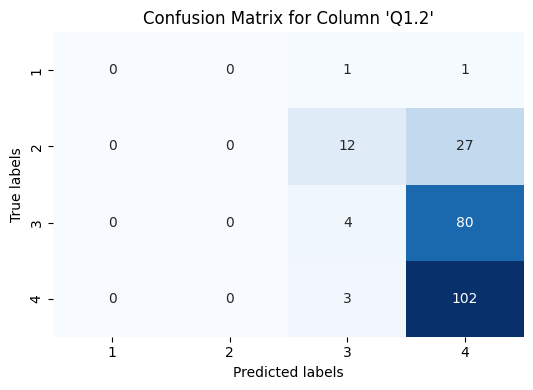

In [93]:

columns_to_consider = ["Q1.2"]
possible_values = {
    'Q1.2': ['1', '2', '3', '4'],
}

conf_matrices = calculate_confusion_matrix('Manuel','ChatGPT4AsAnnotator', columns_to_consider, possible_values)


### Rimuovo i valori estrami facendolo diventare un binario:



Q1.2: How accurately does the story’s headline describe the content of the story? (Check one):<br>
    1.  Inaccurately <br>
    4.  Accurately<br>


In [94]:
# Sostituisci i valori 3 con 4 e i valori 2 con 1 nella nuova colonna
df['Q1.2_binary'] = df['Q1.2'].replace({3: 4, 2: 1})

# Elimina i valori -1
df = df[df['Q1.2_binary'] != -1]

df['Q1.2_binary'].unique()



array([1, 4])

### Rifaccio il K

In [95]:
opzionale = False
numerica = True

inter_annotator_agreement(df, 'Q1.2_binary', 'Manuel', 'Angelo', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.2_binary', 'Manuel', 'Marinella', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.2_binary', 'Angelo', 'Marinella', opzionale, numerica)
print('----------------------------------')
inter_annotator_agreement(df, 'Q1.2_binary', 'Manuel', 'ChatGPT4AsAnnotator', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.2_binary', 'Marinella', 'ChatGPT4AsAnnotator', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.2_binary', 'Angelo', 'ChatGPT4AsAnnotator', opzionale, numerica)


Kappa tra Manuel e Angelo per Q1.2_binary: 0.452054794520548
Kappa tra Manuel e Marinella per Q1.2_binary: 0.3555992141453831
Kappa tra Angelo e Marinella per Q1.2_binary: 0.42827868852459017
----------------------------------
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.2_binary: 0.0
Kappa tra Marinella e ChatGPT4AsAnnotator per Q1.2_binary: 0.0
Kappa tra Angelo e ChatGPT4AsAnnotator per Q1.2_binary: 0.0


Il K non funziona perché chatGPT ha solo una classe se si semplifica ovvero la 4 e non va bene per la formula del K che da zero in questo caso

### Faccio la CM

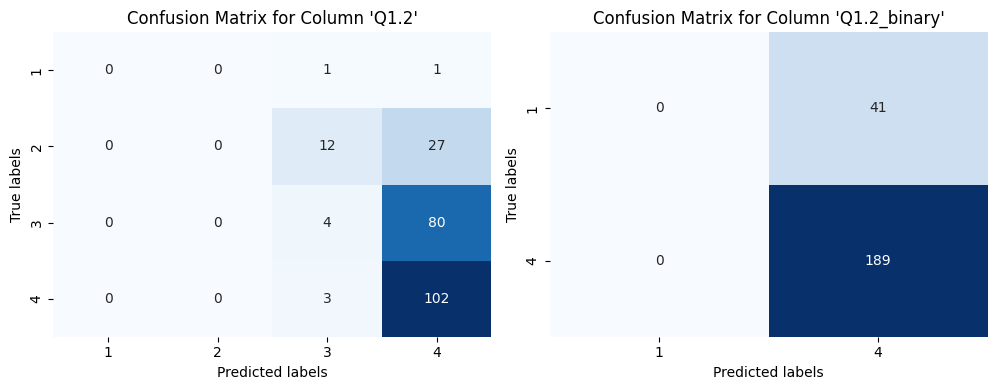

In [96]:


columns_to_consider = ["Q1.2", "Q1.2_binary"]
possible_values = {
    'Q1.2': ['1', '2', '3', '4'],
    'Q1.2_binary': ['1', '4'],

}

conf_matrices = calculate_confusion_matrix('Manuel','ChatGPT4AsAnnotator', columns_to_consider, possible_values)


# Q 1.3

## Questions

### Original

Q1.3: Does the story’s headline contain any of the following elements? (Check all that apply):<br>
    1.  A proper noun<br>
    2.  A question<br>
    3.  A colon<br>
    4.  A quotation<br>
    5.  Words or phrases that are entirely capitalized (all caps)<br>
    6.  The pronoun 'this'<br>
    7.  Generalizing terms (ex: 'never', 'always')<br>
    8.  Explanation phrases, such as 'Here’s why...'<br>
    9.  Hyperbolic, emotional or sensationalized language<br>


### Revisited

Step 8 - Does the story’s headline contain any of the following elements? (Specify for each option "Yes" if the element appears in the title, "No" oyherwise):
    1.  A proper noun 
    2.  A colon (:)
    3.  A question
    4.  Presence of quoted text
    5.  Presence of at least one word written in capital letters
    6.  The pronoun 'questo' and its derivatives
    7.  Generalizing terms (such as 'mai', 'sempre')
    8.  Explanation phrases, such as 'Ecco perché...'

Step 9 - Does the story’s headline contain hyperbolic, emotional, or sensationalistic language:
    1.  No
    2.  Yes


## Analisi

In [97]:
df['Q1.3'].unique()

array(['3', '1;3', '3;9', '1;3;5', '1;3;4', '1;4', '4;9', '3;4', '1', '9',
       '-1', '1;3;9', '1;9', '1;5', '1;2;4', '1;2;3;4', '1;3;8', '1;8',
       '1;3;4;9', '1;2;3;4;9', '1;3;4;7;9', '3;4;9', '1;2', '1;3;5;9',
       '3;4;8', '7', '2;3', '1;5;9', '4;8', '8', '3;8', '3;6', '4', '5',
       '2', '1;2;9', '1;4;8;9', '1;3;4;5;9', '1;2;3;4;5;9', '1;2;8;9',
       '1;3;8;9', '1;2;4;9', '1;4;9', '1;7;9', '1;8;9', '1;4;5;9',
       '1;3;4;5;6;9', '1;4;5', '1;4;7', '1;2;3;8', '1;2;3', '1;3;5;8;9',
       '1;2;3;5;9', '1;2;3;8;9', '1;3;4;5', '1;5;8'], dtype=object)

In [98]:
opzionale = True

inter_annotator_agreement(df, 'Q1.3', 'Manuel', 'Angelo', opzionale)
inter_annotator_agreement(df, 'Q1.3', 'Manuel', 'Marinella', opzionale)
inter_annotator_agreement(df, 'Q1.3', 'Angelo', 'Marinella', opzionale)
print('----------------------------------')
inter_annotator_agreement(df, 'Q1.3', 'Manuel', 'ChatGPT4AsAnnotator', opzionale)
inter_annotator_agreement(df, 'Q1.3', 'Marinella', 'ChatGPT4AsAnnotator', opzionale)
inter_annotator_agreement(df, 'Q1.3', 'Angelo', 'ChatGPT4AsAnnotator', opzionale)

Kappa tra Manuel e Angelo per Q1.3: 0.591187032903038
Kappa tra Manuel e Marinella per Q1.3: 0.6984139146425561
Kappa tra Angelo e Marinella per Q1.3: 0.6189028420356907
----------------------------------
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.3: 0.19845393486250162
Kappa tra Marinella e ChatGPT4AsAnnotator per Q1.3: 0.22891791480711277
Kappa tra Angelo e ChatGPT4AsAnnotator per Q1.3: 0.24022066198595782


### Creo colonne singole per ciascun valore possibile nella colonna e salvo in un nuovo dataframe

In [99]:
# Dividi la colonna 'Q1.3' in colonne separate
df_split = df['Q1.3'].str.get_dummies(sep=';')

# Rinomina le colonne con i valori unici
df_split.columns = ['Q1.3_' + col for col in df_split.columns]

# Unisci il dataframe diviso con il dataframe originale
df_1_3 = pd.concat([df, df_split], axis=1)

# Mostra il dataframe risultante
df_1_3 = df_1_3.loc[:, ['id','annotator','Q1.3_-1','Q1.3_1','Q1.3_2','Q1.3_3','Q1.3_4','Q1.3_5','Q1.3_6','Q1.3_7','Q1.3_8','Q1.3_9']]

df_1_3

,id,annotator,Q1.3_-1,Q1.3_1,Q1.3_2,Q1.3_3,Q1.3_4,Q1.3_5,Q1.3_6,Q1.3_7,Q1.3_8,Q1.3_9
0,18d71db7-f362-46fa-953e-d8353c7f7232,Manuel,0,0,0,1,0,0,0,0,0,0
1,18d71db7-f362-46fa-953e-d8353c7f7232,Angelo,0,1,0,1,0,0,0,0,0,0
2,3ca70f03-38f3-4a7b-bdd3-f012b22e0c7e,Manuel,0,1,0,1,0,0,0,0,0,0
3,3ca70f03-38f3-4a7b-bdd3-f012b22e0c7e,Marinella,0,1,0,1,0,0,0,0,0,0
4,34b92f4c-32db-454c-a369-ca2032443f6c,Manuel,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1014,3696bc79-2f24-47e2-9f13-fabd92b7a271,ChatGPT4AsAnnotator,0,1,0,1,0,0,0,0,0,0
1015,89ca8966-8ade-49fd-a036-c528a1f7871c,ChatGPT4AsAnnotator,0,1,0,1,0,0,0,0,0,0
1016,a425710b-96e3-4840-87be-75deea62775d,ChatGPT4AsAnnotator,0,1,0,1,0,1,0,0,0,0
1017,df86ebbe-1672-4c99-8895-b0fe742ed00c,ChatGPT4AsAnnotator,0,1,1,0,0,0,0,0,0,0


### Faccio la balanced accuracy

<Figure size 640x480 with 0 Axes>

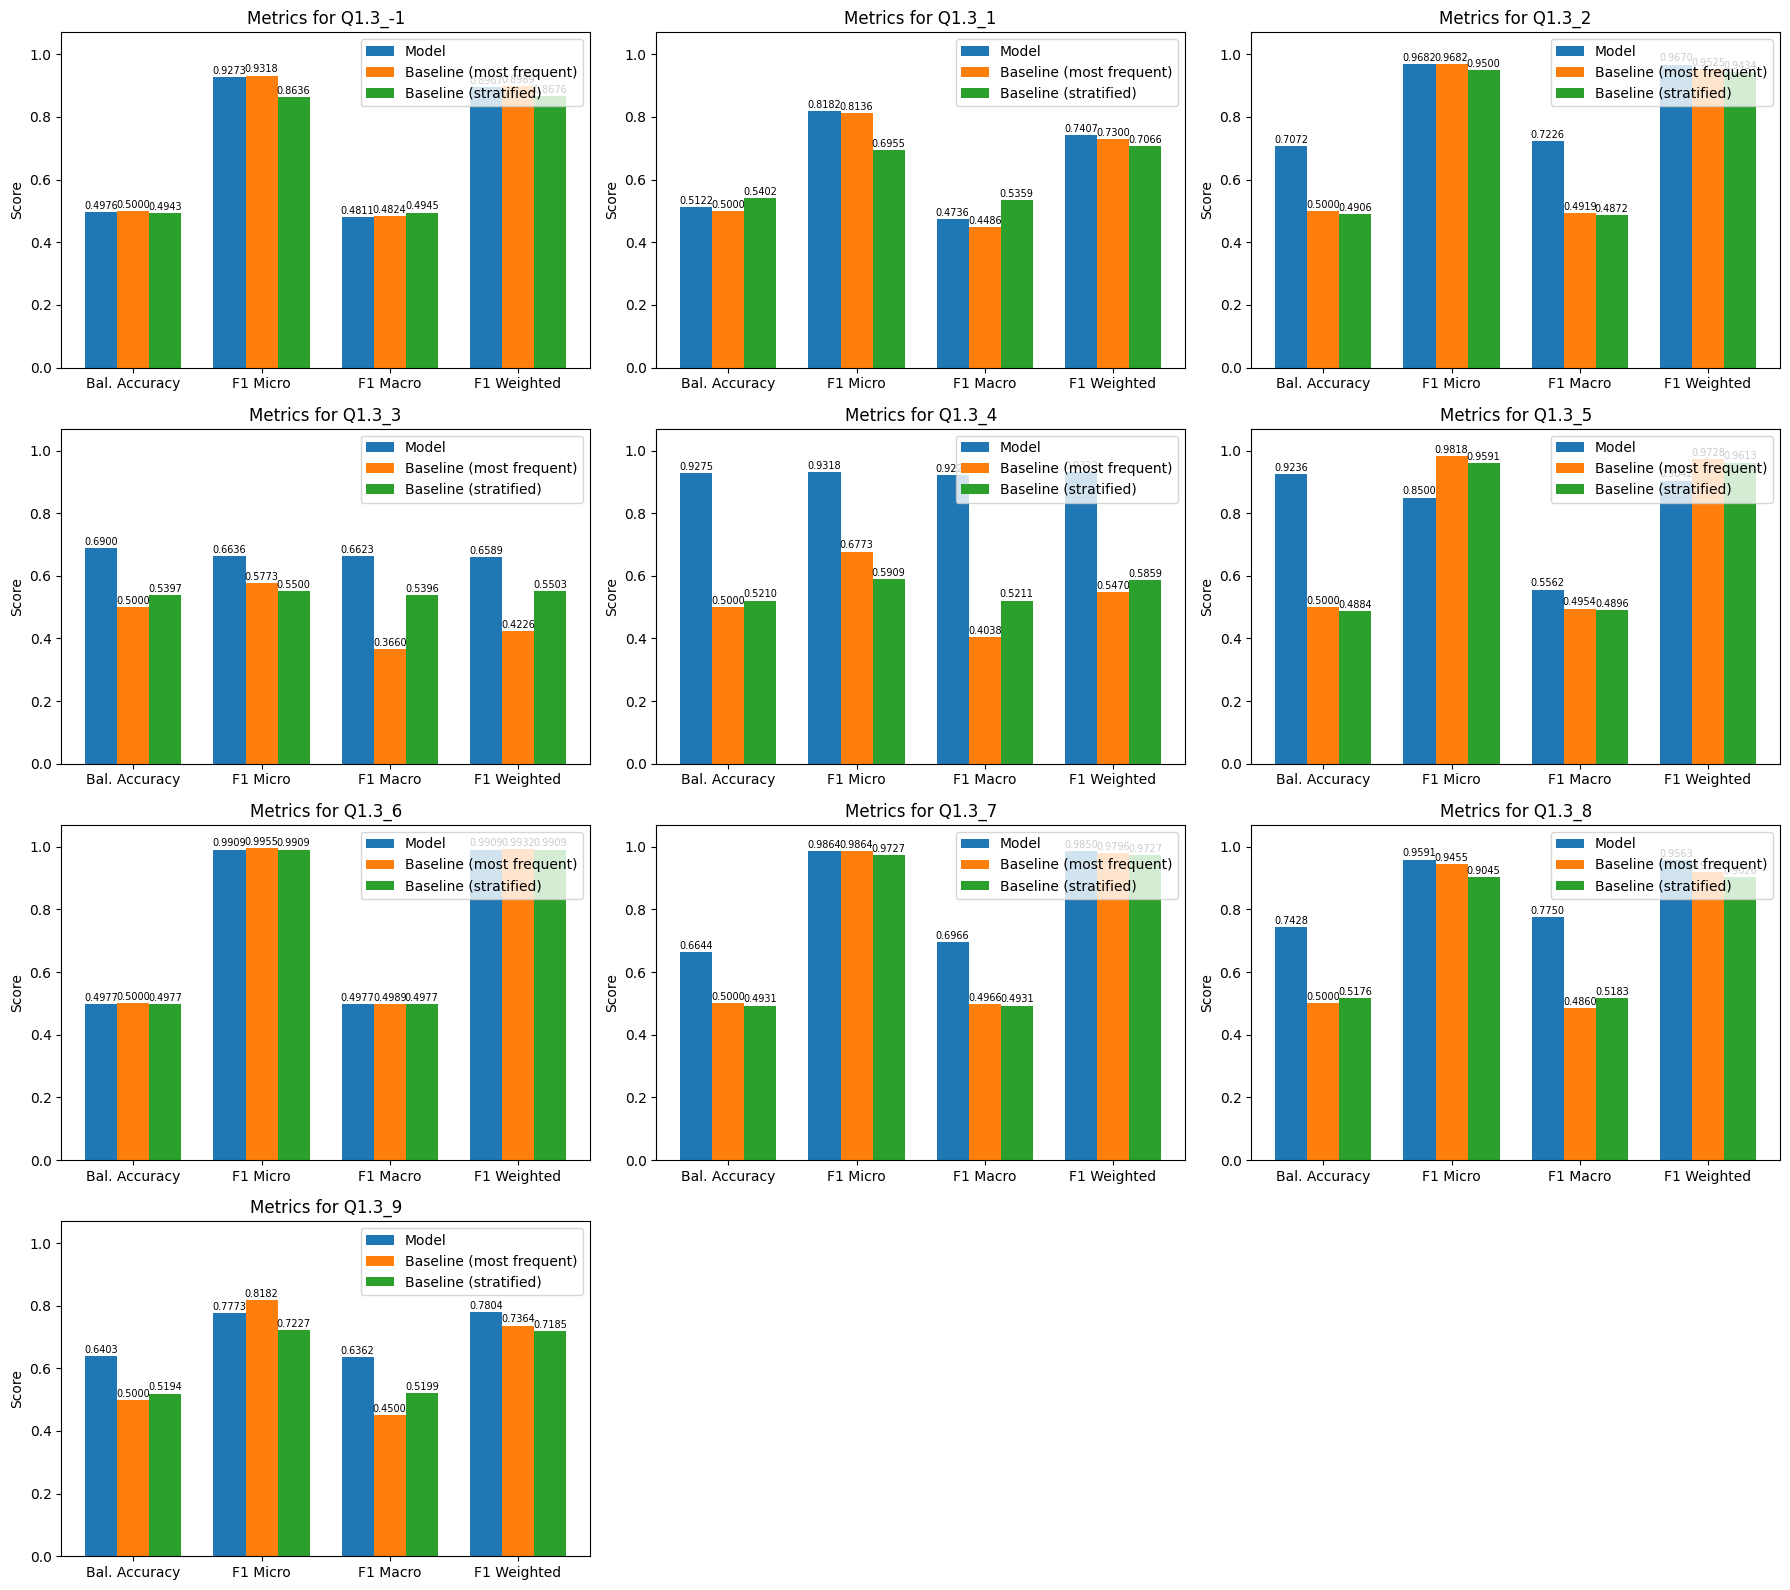

In [100]:
optional = False
calculate_standard_metrics('Marinella', 'ChatGPT4AsAnnotator', df_1_3, optional)

/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

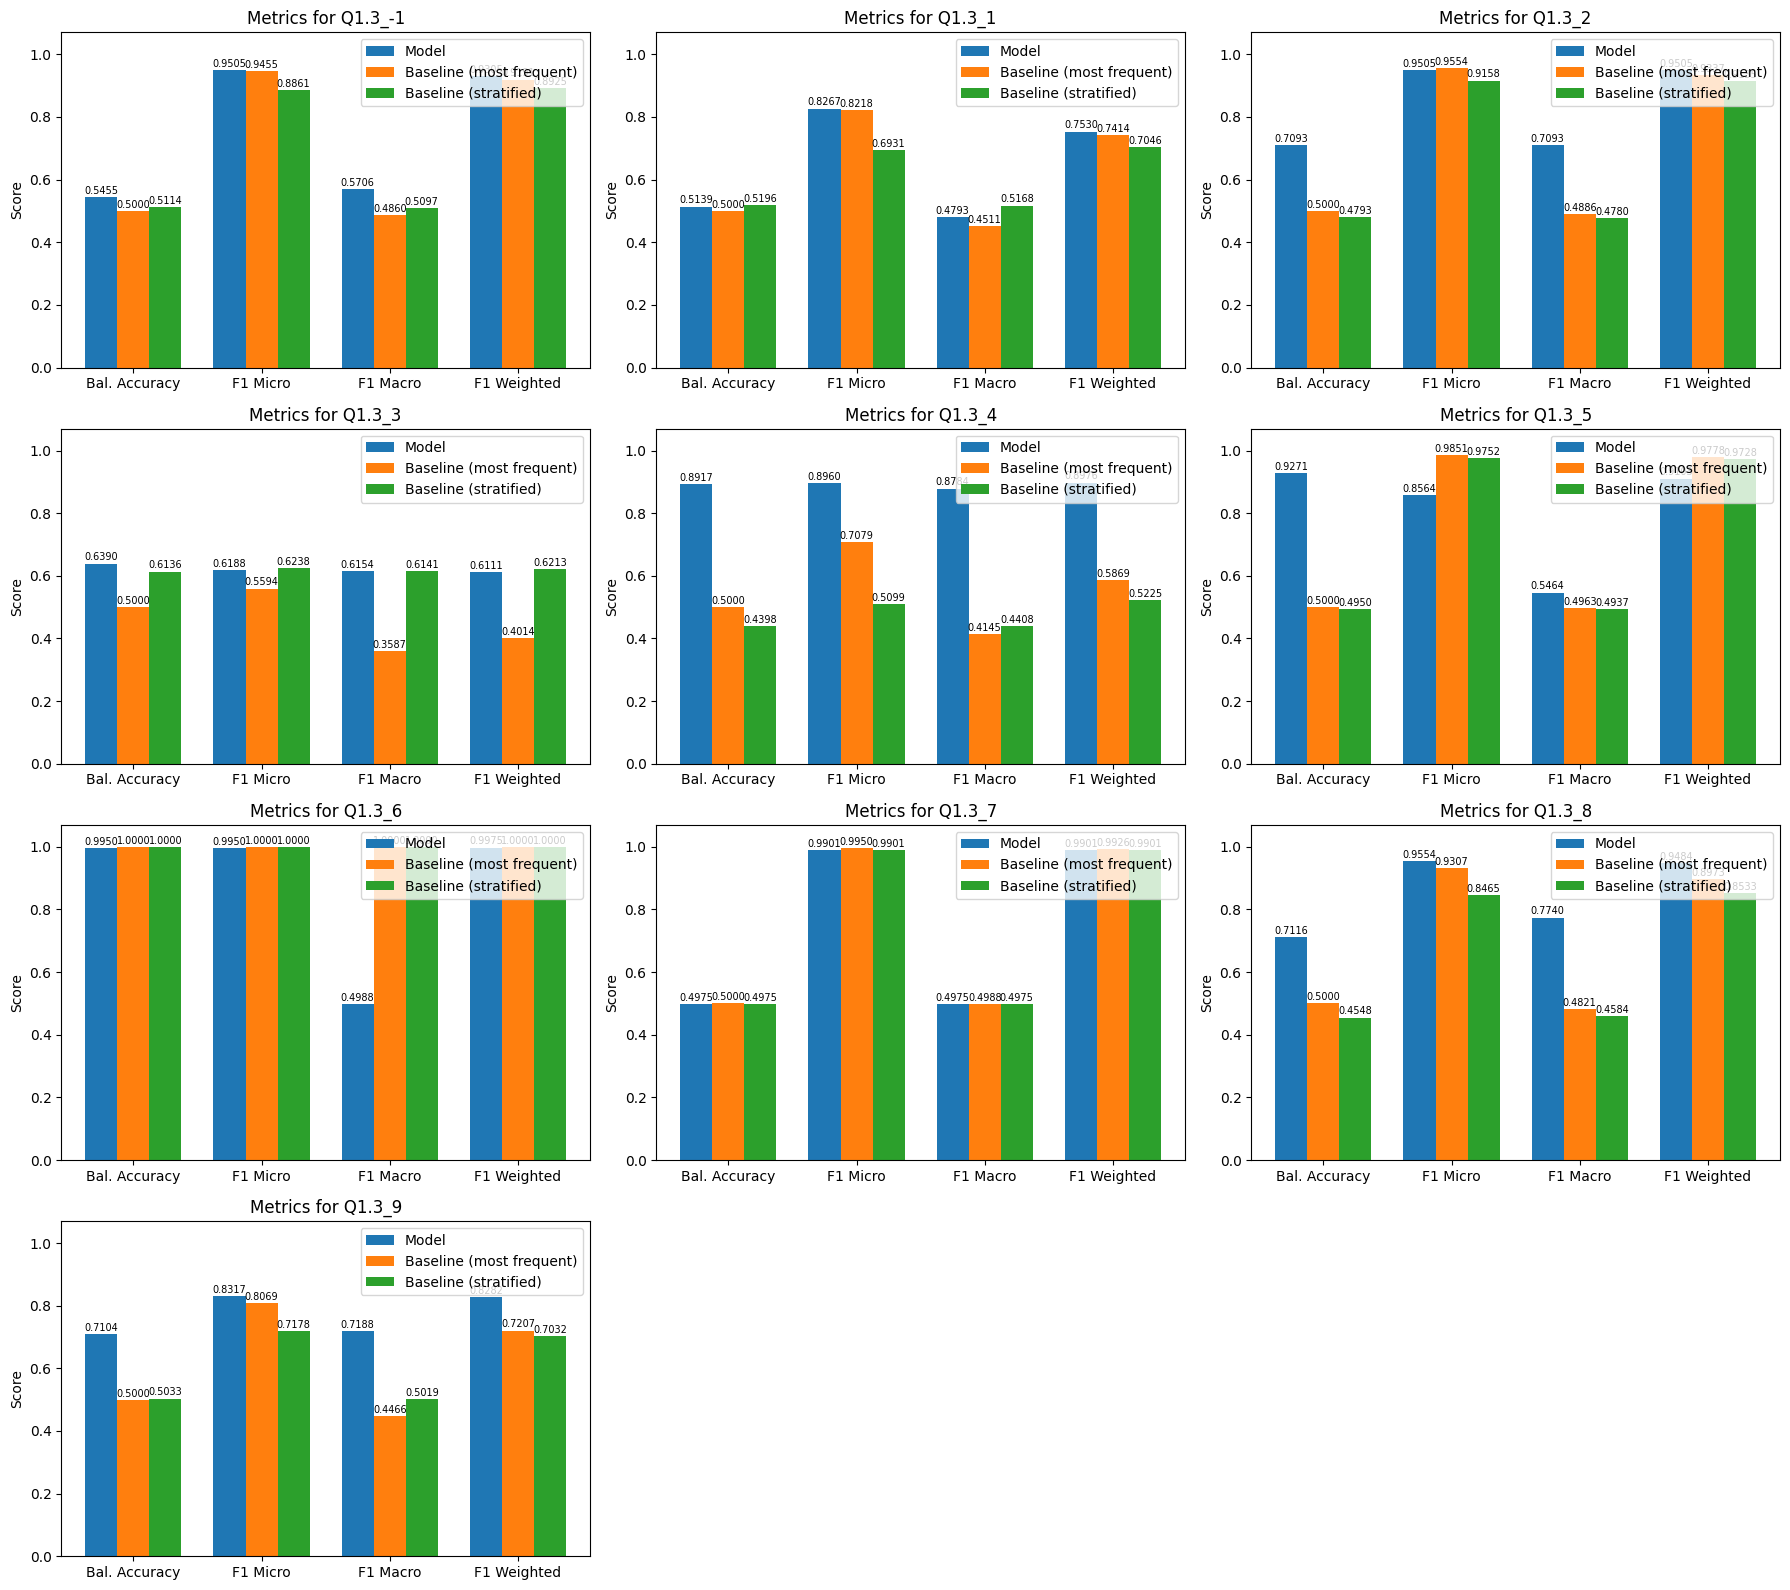

In [101]:
calculate_standard_metrics('Angelo', 'ChatGPT4AsAnnotator', df_1_3, optional)

/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/john/Progetti/ChatGPTAsAnnotator/Chat

<Figure size 640x480 with 0 Axes>

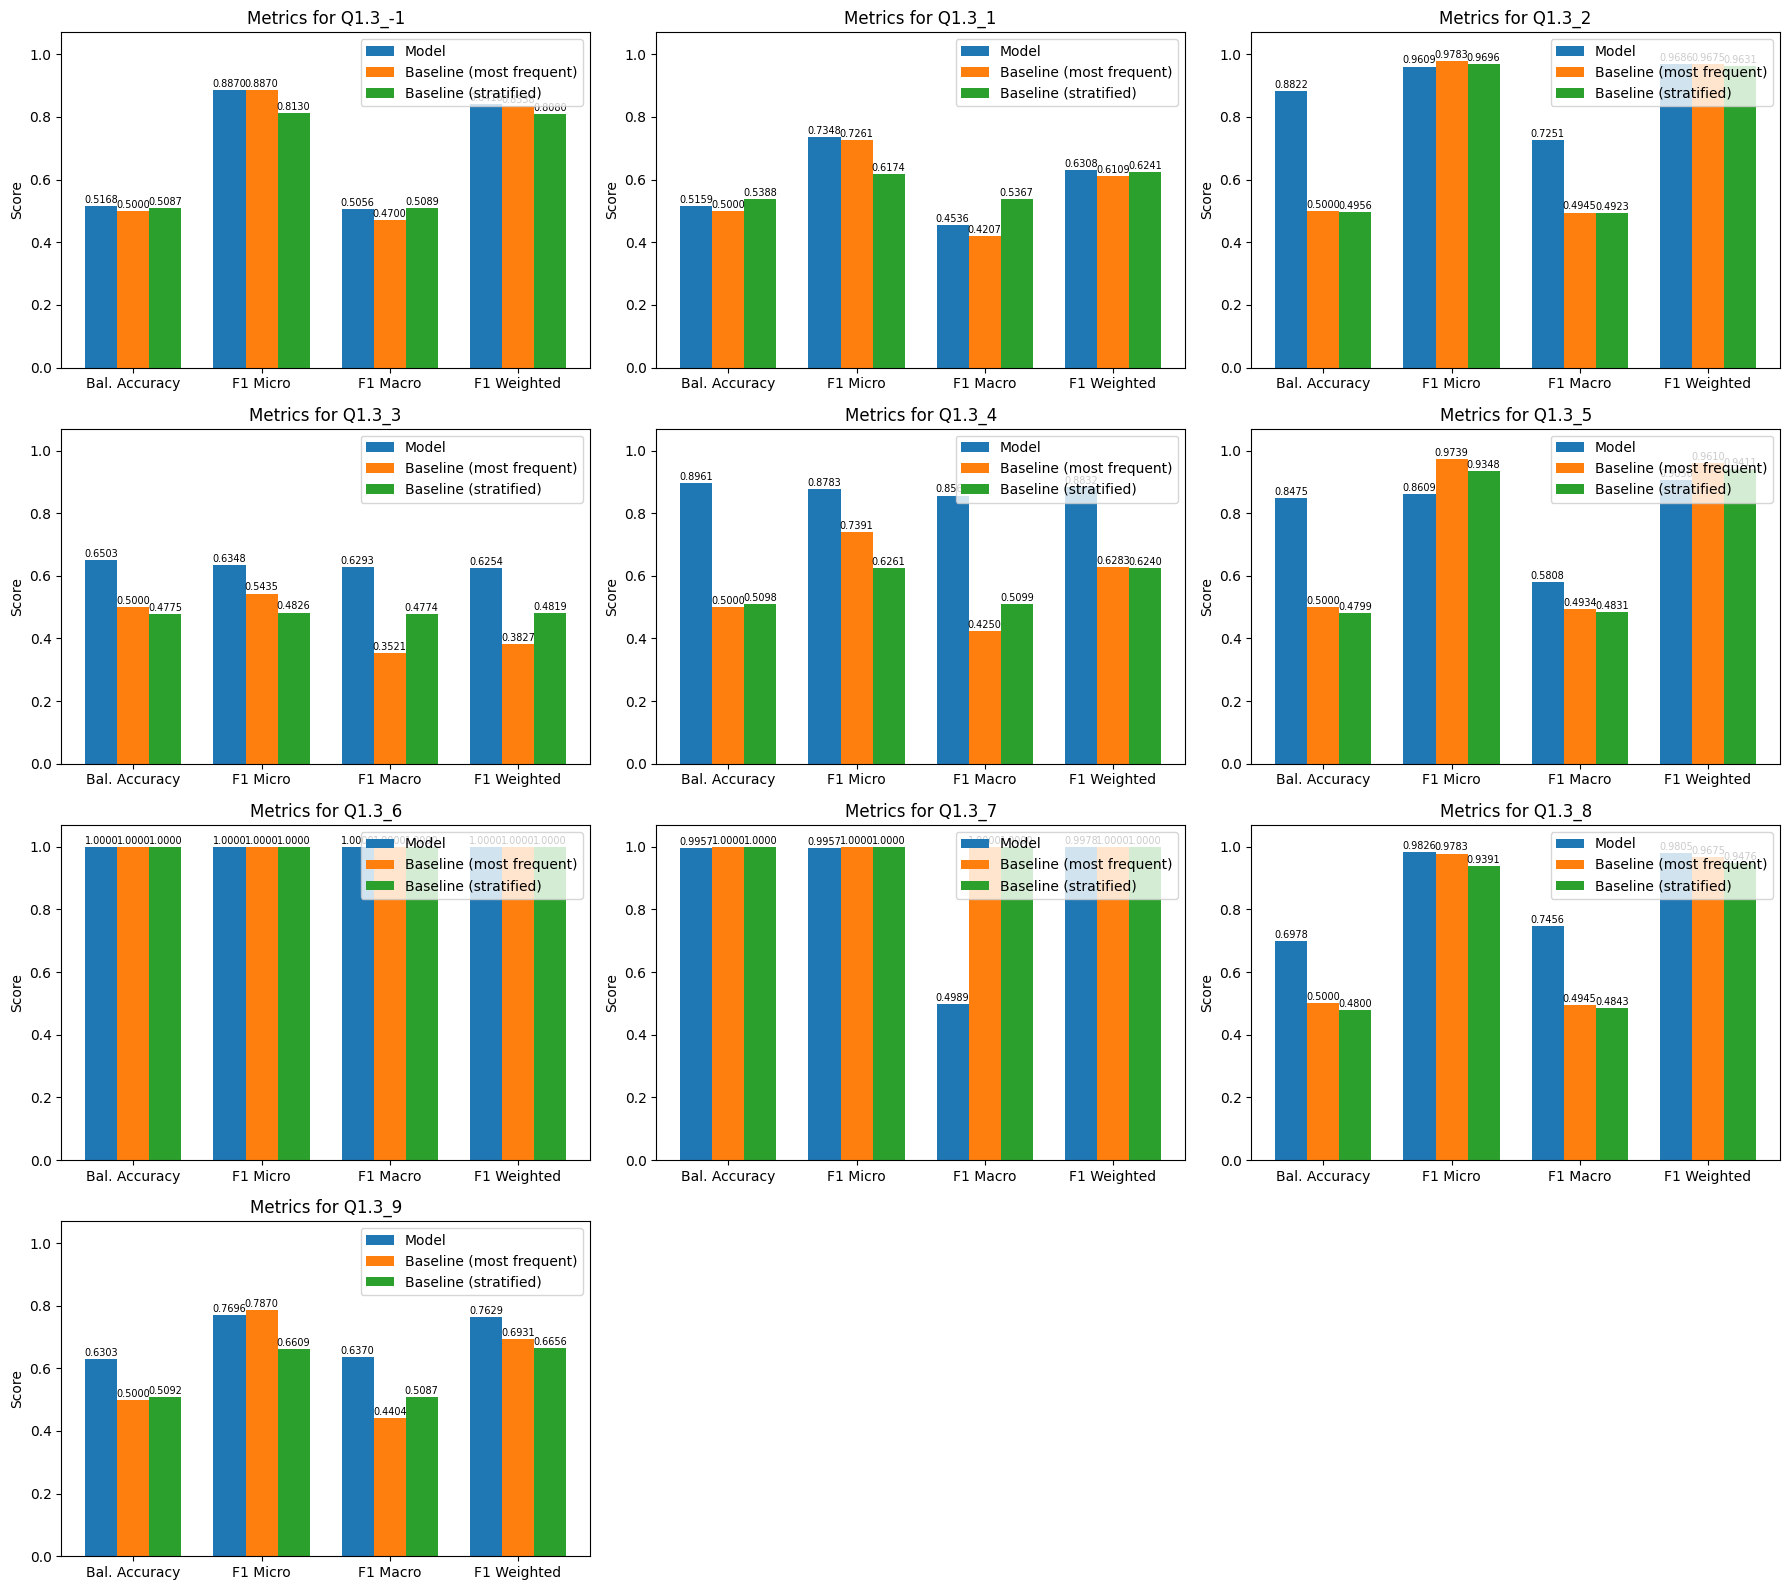

In [102]:
calculate_standard_metrics('Manuel', 'ChatGPT4AsAnnotator', df_1_3, optional)

# Q 1.3.1

## Questions

### Original

Q1.3.1: If the headline contains a quotation, does that same quotation appear in the content of the story? (Check one):<br>
    1.  No<br>
    2.  Yes<br>
    -1. No quotation present<br>


### Reviseted

Step 10 - If the headline contains quoted text, does that same quoted text appear in the story's content? (Check one):<br>
    1.  No<br>
    2.  Yes<br>
    -1. No quotation present


## Analisi

In [103]:
df['Q1.3.1'].unique()

array([-1,  1,  2])

In [104]:
opzionale = True

inter_annotator_agreement(df, 'Q1.3.1', 'Manuel', 'Angelo', opzionale)
inter_annotator_agreement(df, 'Q1.3.1', 'Manuel', 'Marinella', opzionale)
inter_annotator_agreement(df, 'Q1.3.1', 'Angelo', 'Marinella', opzionale)
print('----------------------------------')
inter_annotator_agreement(df, 'Q1.3.1', 'Manuel', 'ChatGPT4AsAnnotator', opzionale)
inter_annotator_agreement(df, 'Q1.3.1', 'Marinella', 'ChatGPT4AsAnnotator', opzionale)
inter_annotator_agreement(df, 'Q1.3.1', 'Angelo', 'ChatGPT4AsAnnotator', opzionale)


Kappa tra Manuel e Angelo per Q1.3.1: 0.7199170124481328
Kappa tra Manuel e Marinella per Q1.3.1: 0.5887345679012346
Kappa tra Angelo e Marinella per Q1.3.1: 0.7249605678233438
----------------------------------
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.3.1: 0.23116147308781876
Kappa tra Marinella e ChatGPT4AsAnnotator per Q1.3.1: 0.14684322534878236
Kappa tra Angelo e ChatGPT4AsAnnotator per Q1.3.1: 0.15771679720516152


### Il problema è che il nostro non dice mai di 'No' ma solamente che non c'è (-1) o che c'è (2)

In [105]:
df_filtered = df[df['annotator'] == 'Marinella']
df_filtered['Q1.3.1'].unique()

array([-1,  1,  2])

In [106]:
df_filtered = df[df['annotator'] == 'ChatGPT4AsAnnotator']
df_filtered['Q1.3.1'].unique()

array([-1,  2])

### CM

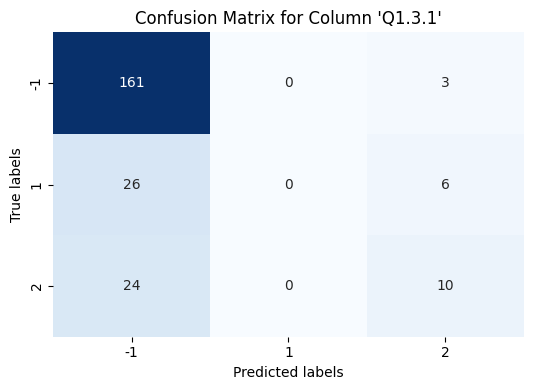

In [107]:
columns_to_consider = ["Q1.3.1"]
possible_values = {
    'Q1.3.1': ['-1', '1', '2'],
}

conf_matrices = calculate_confusion_matrix('Manuel','ChatGPT4AsAnnotator', columns_to_consider, possible_values)


# Q 1.4

## Questions

### Original

Q1.4: Does the article begin with a fact-based lead? (Check one):<br>
    1.  No<br>
    2.  Yes<br>


### Revisited

Step 11 - Does the first sentence of the text of this article clearly summarize the main fact that a news article is about by answering the where, when, how, and why of the fact described?<br><br>
No<br>
Yes<br>


## Analisi

In [108]:
df['Q1.4'].unique()

array([ 2,  1, -1])

### K

In [109]:
opzionale = False

inter_annotator_agreement(df, 'Q1.4', 'Manuel', 'Angelo', opzionale)
inter_annotator_agreement(df, 'Q1.4', 'Manuel', 'Marinella', opzionale)
inter_annotator_agreement(df, 'Q1.4', 'Angelo', 'Marinella', opzionale)
print('----------------------------------')
inter_annotator_agreement(df, 'Q1.4', 'Manuel', 'ChatGPT4AsAnnotator', opzionale)
inter_annotator_agreement(df, 'Q1.4', 'Marinella', 'ChatGPT4AsAnnotator', opzionale)
inter_annotator_agreement(df, 'Q1.4', 'Angelo', 'ChatGPT4AsAnnotator', opzionale)


Kappa tra Manuel e Angelo per Q1.4: 0.3913118427857266
Kappa tra Manuel e Marinella per Q1.4: 0.5313475177304965
Kappa tra Angelo e Marinella per Q1.4: 0.3157894736842105
----------------------------------
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.4: 0.36450913595540424
Kappa tra Marinella e ChatGPT4AsAnnotator per Q1.4: 0.10825827089822382
Kappa tra Angelo e ChatGPT4AsAnnotator per Q1.4: 0.14751582582006517


### CM

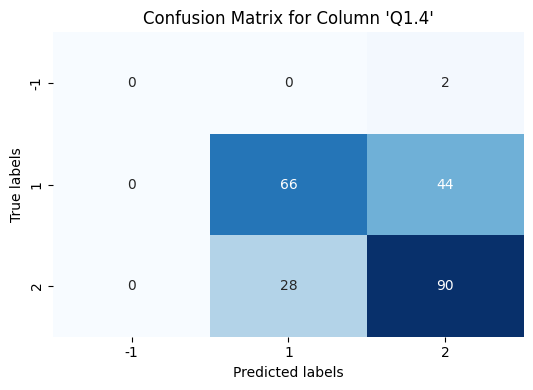

In [110]:
columns_to_consider = ["Q1.4"]
possible_values = {
    'Q1.4': ['-1', '1', '2'],
}

conf_matrices = calculate_confusion_matrix('Manuel','ChatGPT4AsAnnotator', columns_to_consider, possible_values)


# Q 1.5

## Questions

### Original

Q1.5 Please rate the degree of bias in the article copy (Check one):<br>
    1.  Extremely biased<br>
    2.  Mostly biased<br>
    3.  Somewhat biased<br>
    4.  Entirely unbiased<br>


### Revisited

Step 12 - Please rate the degree of bias in the article copy:<br>
    1.  Extremely Biased<br>
    2.  Biased<br>
    3.  Partly biased<br>
    4.  Unbiased<br>


## Analisi

### K

In [111]:
opzionale = False
numerica = True

inter_annotator_agreement(df, 'Q1.5', 'Manuel', 'Angelo', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.5', 'Manuel', 'Marinella', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.5', 'Angelo', 'Marinella', opzionale, numerica)
print('----------------------------------')
inter_annotator_agreement(df, 'Q1.5', 'Manuel', 'ChatGPT4AsAnnotator', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.5', 'Marinella', 'ChatGPT4AsAnnotator', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.5', 'Angelo', 'ChatGPT4AsAnnotator', opzionale, numerica)


Kappa tra Manuel e Angelo per Q1.5: 0.5023041474654377
Kappa tra Manuel e Marinella per Q1.5: 0.424062584299973
Kappa tra Angelo e Marinella per Q1.5: 0.5871254162042175
----------------------------------
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.5: 0.29191431136956436
Kappa tra Marinella e ChatGPT4AsAnnotator per Q1.5: 0.39038970521128047
Kappa tra Angelo e ChatGPT4AsAnnotator per Q1.5: 0.2797370327037718


### CM

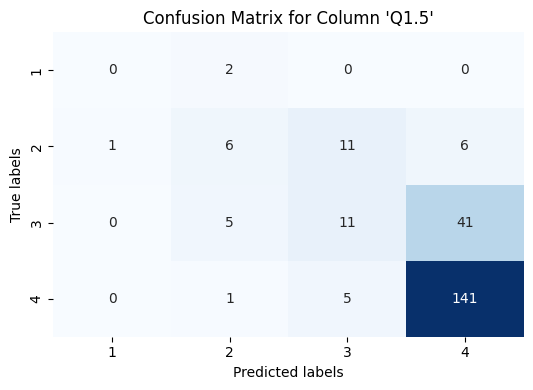

In [112]:

columns_to_consider = ["Q1.5"]
possible_values = {
    'Q1.5': ['1', '2', '3', '4'],
}

conf_matrices = calculate_confusion_matrix('Manuel','ChatGPT4AsAnnotator', columns_to_consider, possible_values)


### Trasformo in binaria

In [113]:
# Sostituisci i valori 3 con 4 e i valori 2 con 1 nella nuova colonna
df['Q1.5_binary'] = df['Q1.5'].replace({3: 4, 2: 1})

# Elimina i valori -1
df = df[df['Q1.5_binary'] != -1]

df['Q1.5_binary'].unique()


/tmp/ipykernel_3996/1549838993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Q1.5_binary'] = df['Q1.5'].replace({3: 4, 2: 1})


array([4, 1])

### Calcolo di nuovo le performance

In [114]:
opzionale = False
numerica = True

inter_annotator_agreement(df, 'Q1.5_binary', 'Manuel', 'Angelo', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.5_binary', 'Manuel', 'Marinella', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.5_binary', 'Angelo', 'Marinella', opzionale, numerica)
print('----------------------------------')
inter_annotator_agreement(df, 'Q1.5_binary', 'Manuel', 'ChatGPT4AsAnnotator', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.5_binary', 'Marinella', 'ChatGPT4AsAnnotator', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.5_binary', 'Angelo', 'ChatGPT4AsAnnotator', opzionale, numerica)


Kappa tra Manuel e Angelo per Q1.5_binary: 0.7037617554858935
Kappa tra Manuel e Marinella per Q1.5_binary: 0.6006546644844517
Kappa tra Angelo e Marinella per Q1.5_binary: 0.7525279403938265
----------------------------------
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.5_binary: 0.38843930635838153
Kappa tra Marinella e ChatGPT4AsAnnotator per Q1.5_binary: 0.8032849993583986
Kappa tra Angelo e ChatGPT4AsAnnotator per Q1.5_binary: 0.5590723055934516


# Q 1.6

## Questions

### Original

Q1.6 Does the article use sensationalised language? (Check one):<br>
    1.  Extremely sensationalised<br>
    2.  Somewhat sensationalised<br>
    3.  Mainly neutral<br>
    4.  Entirely neutral<br>


### Reviseted

Step 13 - Does the article use sensationalized language?:<br>
    1.  Extremely sensationalised<br>
    2.  Sensationalised<br>
    3.  Partly neutral<br>
    4.  Neutral<br>


## Analisi

In [115]:
df['Q1.6'].unique()

array([4, 2, 3, 1])

### K

In [116]:
opzionale = False
numerica = True

inter_annotator_agreement(df, 'Q1.6', 'Manuel', 'Angelo', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.6', 'Manuel', 'Marinella', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.6', 'Angelo', 'Marinella', opzionale, numerica)
print('----------------------------------')
inter_annotator_agreement(df, 'Q1.6', 'Manuel', 'ChatGPT4AsAnnotator', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.6', 'Marinella', 'ChatGPT4AsAnnotator', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.6', 'Angelo', 'ChatGPT4AsAnnotator', opzionale, numerica)


Kappa tra Manuel e Angelo per Q1.6: 0.5731225296442688
Kappa tra Manuel e Marinella per Q1.6: 0.4616370106761566
Kappa tra Angelo e Marinella per Q1.6: 0.579470947320823
----------------------------------
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.6: 0.30618401206636503
Kappa tra Marinella e ChatGPT4AsAnnotator per Q1.6: 0.2563667232597623
Kappa tra Angelo e ChatGPT4AsAnnotator per Q1.6: 0.3110752109136601


### CM

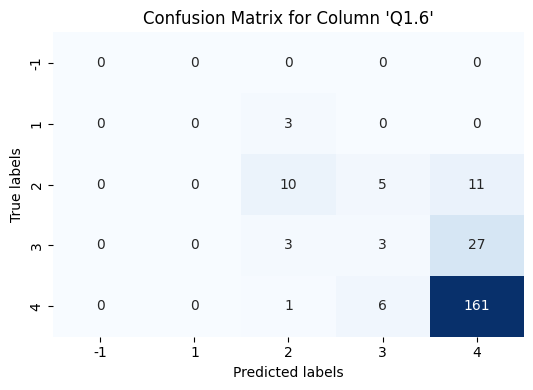

In [117]:
columns_to_consider = ["Q1.6"]
possible_values = {
    'Q1.6': ['-1', '1', '2', '3', '4'],
}

conf_matrices = calculate_confusion_matrix('Manuel','ChatGPT4AsAnnotator', columns_to_consider, possible_values)


### Trasformo in binaria

In [118]:
# Sostituisci i valori 3 con 4 e i valori 2 con 1 nella nuova colonna
df['Q1.6_binary'] = df['Q1.6'].replace({3: 4, 2: 1})

# Elimina i valori -1
df = df[df['Q1.6_binary'] != -1]

df['Q1.6_binary'].unique()


array([4, 1])

### Calcolo di nuovo le performance

In [119]:
opzionale = False
numerica = True

inter_annotator_agreement(df, 'Q1.6_binary', 'Manuel', 'Angelo', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.6_binary', 'Manuel', 'Marinella', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.6_binary', 'Angelo', 'Marinella', opzionale, numerica)
print('----------------------------------')
inter_annotator_agreement(df, 'Q1.6_binary', 'Manuel', 'ChatGPT4AsAnnotator', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.6_binary', 'Marinella', 'ChatGPT4AsAnnotator', opzionale, numerica)
inter_annotator_agreement(df, 'Q1.6_binary', 'Angelo', 'ChatGPT4AsAnnotator', opzionale, numerica)

Kappa tra Manuel e Angelo per Q1.6_binary: 0.6415929203539823
Kappa tra Manuel e Marinella per Q1.6_binary: 0.5995623632385121
Kappa tra Angelo e Marinella per Q1.6_binary: 0.7694595934556272
----------------------------------
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.6_binary: 0.5205336668751304
Kappa tra Marinella e ChatGPT4AsAnnotator per Q1.6_binary: 0.30410733199952933
Kappa tra Angelo e ChatGPT4AsAnnotator per Q1.6_binary: 0.543789209535759


# Q 1.7

## Questions

### Original

Q1.7: Does this story negatively target a specific group or individual? (Check one):<br>
    1.  No<br>
    2.  Yes<br>


### Reviseted

Step 14 - Does this story negatively target a specific group or individual?:<br>
    1.  No<br>
    2.  Yes<br>


## Analisi

In [120]:
df['Q1.7'].unique()

array([ 1,  2, -1])

### K

In [121]:
opzionale = False

inter_annotator_agreement(df, 'Q1.7', 'Manuel', 'Angelo', opzionale)
inter_annotator_agreement(df, 'Q1.7', 'Manuel', 'Marinella', opzionale)
inter_annotator_agreement(df, 'Q1.7', 'Angelo', 'Marinella', opzionale)
print('----------------------------------')
inter_annotator_agreement(df, 'Q1.7', 'Manuel', 'ChatGPT4AsAnnotator', opzionale)
inter_annotator_agreement(df, 'Q1.7', 'Marinella', 'ChatGPT4AsAnnotator', opzionale)
inter_annotator_agreement(df, 'Q1.7', 'Angelo', 'ChatGPT4AsAnnotator', opzionale)


Kappa tra Manuel e Angelo per Q1.7: 0.6685440720923683
Kappa tra Manuel e Marinella per Q1.7: 0.6908783783783784
Kappa tra Angelo e Marinella per Q1.7: 0.7080028839221342
----------------------------------
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.7: 0.4677728863302856
Kappa tra Marinella e ChatGPT4AsAnnotator per Q1.7: 0.5616653574234092
Kappa tra Angelo e ChatGPT4AsAnnotator per Q1.7: 0.5556051808843234


### CM

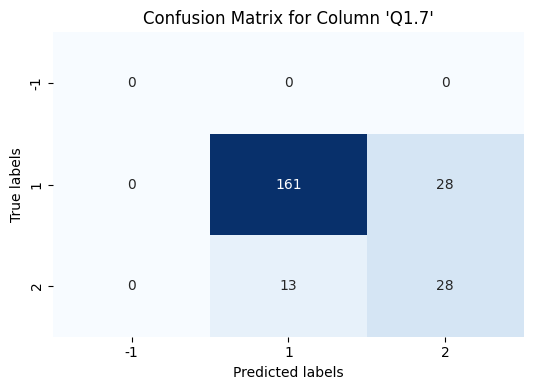

In [122]:
columns_to_consider = ["Q1.7"]
possible_values = {
    'Q1.7': ['-1', '1', '2'],
}

conf_matrices = calculate_confusion_matrix('Manuel','ChatGPT4AsAnnotator', columns_to_consider, possible_values)


# Q 1.7.1

## Questions

### Original

Q1.7.1: If the answer 1.7 is yes, please specify the group or individual negatively target. (Check all that apply):<br>
0.  Conservatives<br>
1.  Liberals<br>
2.  Gender<br>
3.  LGBTQ<br>
4.  Immigrants<br>
5.  Jews/Judaism<br>
6.  Islam/Muslims<br>
7.  Christians/Christianity<br>
8.  Religion (Other)<br>
9.  Race/ethnicity<br>
10.  Reputation (Organisation)<br>
11.  Reputation (Person)<br>
12.  Other<br>


### Reviseted

Step 15 - Specify the group or individual negatively targeted. Specify for each option "Yes" if the element appears in the title, "No" oyherwise):<br>
    0.  Political<br>
    1.  Religion<br>
    2.  Race/ethnicity<br>
    3.  Orientation<br>
    4.  The article negatively targets other groups or minorities<br>


## Analisi

In [123]:
df['Q1.7.1'].unique()

array(['-1', '3', '4', '0', '1', '1;3', '2', '1;4', '3;4;2', '3;2', '6',
       '5', '1;3;5', '1;6', '4;5', '3;6', '3;5', '4;6', '2;5', '1;4;6',
       '2;6', '2;3;5;6', '2;3;5', '1;3;4;5'], dtype=object)

### K

In [124]:
opzionale = True

inter_annotator_agreement(df, 'Q1.7.1', 'Manuel', 'Angelo', opzionale)
inter_annotator_agreement(df, 'Q1.7.1', 'Manuel', 'Marinella', opzionale)
inter_annotator_agreement(df, 'Q1.7.1', 'Angelo', 'Marinella', opzionale)
print('----------------------------------')
inter_annotator_agreement(df, 'Q1.7.1', 'Manuel', 'ChatGPT4AsAnnotator', opzionale)
inter_annotator_agreement(df, 'Q1.7.1', 'Marinella', 'ChatGPT4AsAnnotator', opzionale)
inter_annotator_agreement(df, 'Q1.7.1', 'Angelo', 'ChatGPT4AsAnnotator', opzionale)


Kappa tra Manuel e Angelo per Q1.7.1: 0.509090909090909
Kappa tra Manuel e Marinella per Q1.7.1: 0.4774414620217019
Kappa tra Angelo e Marinella per Q1.7.1: 0.4043234587670136
----------------------------------
Kappa tra Manuel e ChatGPT4AsAnnotator per Q1.7.1: -0.0003403804697248436
Kappa tra Marinella e ChatGPT4AsAnnotator per Q1.7.1: -0.0003128519584534306
Kappa tra Angelo e ChatGPT4AsAnnotator per Q1.7.1: 0.0


### Creo colonne singole per ciascun valore possibile nella colonna e salvo in un nuovo dataframe

In [125]:
# Dividi la colonna 'Q1.3' in colonne separate
df_split = df['Q1.7.1'].str.get_dummies(sep=';')

# Rinomina le colonne con i valori unici
df_split.columns = ['Q1.7.1_' + col for col in df_split.columns]

# Unisci il dataframe diviso con il dataframe originale
df_1_7_1 = pd.concat([df, df_split], axis=1)

# Mostra il dataframe risultante
df_1_7_1 = df_1_7_1.loc[:, ['id','annotator','Q1.7.1_-1','Q1.7.1_1','Q1.7.1_2','Q1.7.1_3','Q1.7.1_4']]

df_1_7_1

,id,annotator,Q1.7.1_-1,Q1.7.1_1,Q1.7.1_2,Q1.7.1_3,Q1.7.1_4
0,18d71db7-f362-46fa-953e-d8353c7f7232,Manuel,1,0,0,0,0
1,18d71db7-f362-46fa-953e-d8353c7f7232,Angelo,1,0,0,0,0
2,3ca70f03-38f3-4a7b-bdd3-f012b22e0c7e,Manuel,1,0,0,0,0
3,3ca70f03-38f3-4a7b-bdd3-f012b22e0c7e,Marinella,1,0,0,0,0
4,34b92f4c-32db-454c-a369-ca2032443f6c,Manuel,1,0,0,0,0
...,...,...,...,...,...,...,...
1014,3696bc79-2f24-47e2-9f13-fabd92b7a271,ChatGPT4AsAnnotator,0,0,0,0,0
1015,89ca8966-8ade-49fd-a036-c528a1f7871c,ChatGPT4AsAnnotator,0,0,0,0,0
1016,a425710b-96e3-4840-87be-75deea62775d,ChatGPT4AsAnnotator,0,0,0,0,0
1017,df86ebbe-1672-4c99-8895-b0fe742ed00c,ChatGPT4AsAnnotator,0,0,0,0,0


### Faccio la balanced accuracy

<Figure size 640x480 with 0 Axes>

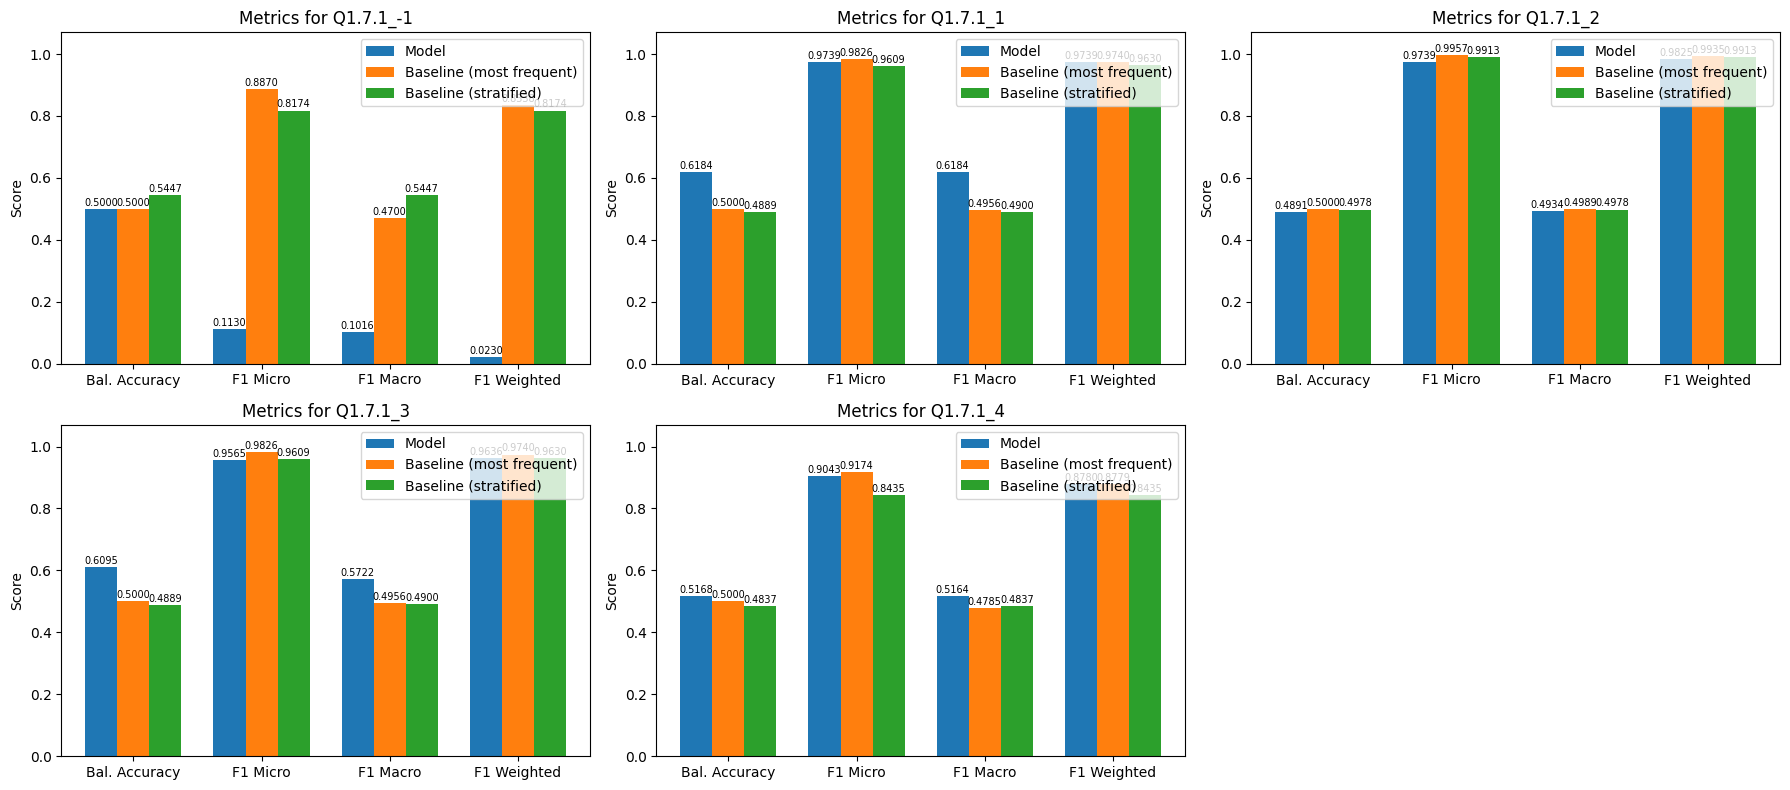

In [126]:
calculate_standard_metrics('Manuel','ChatGPT4AsAnnotator', df_1_7_1)


<Figure size 640x480 with 0 Axes>

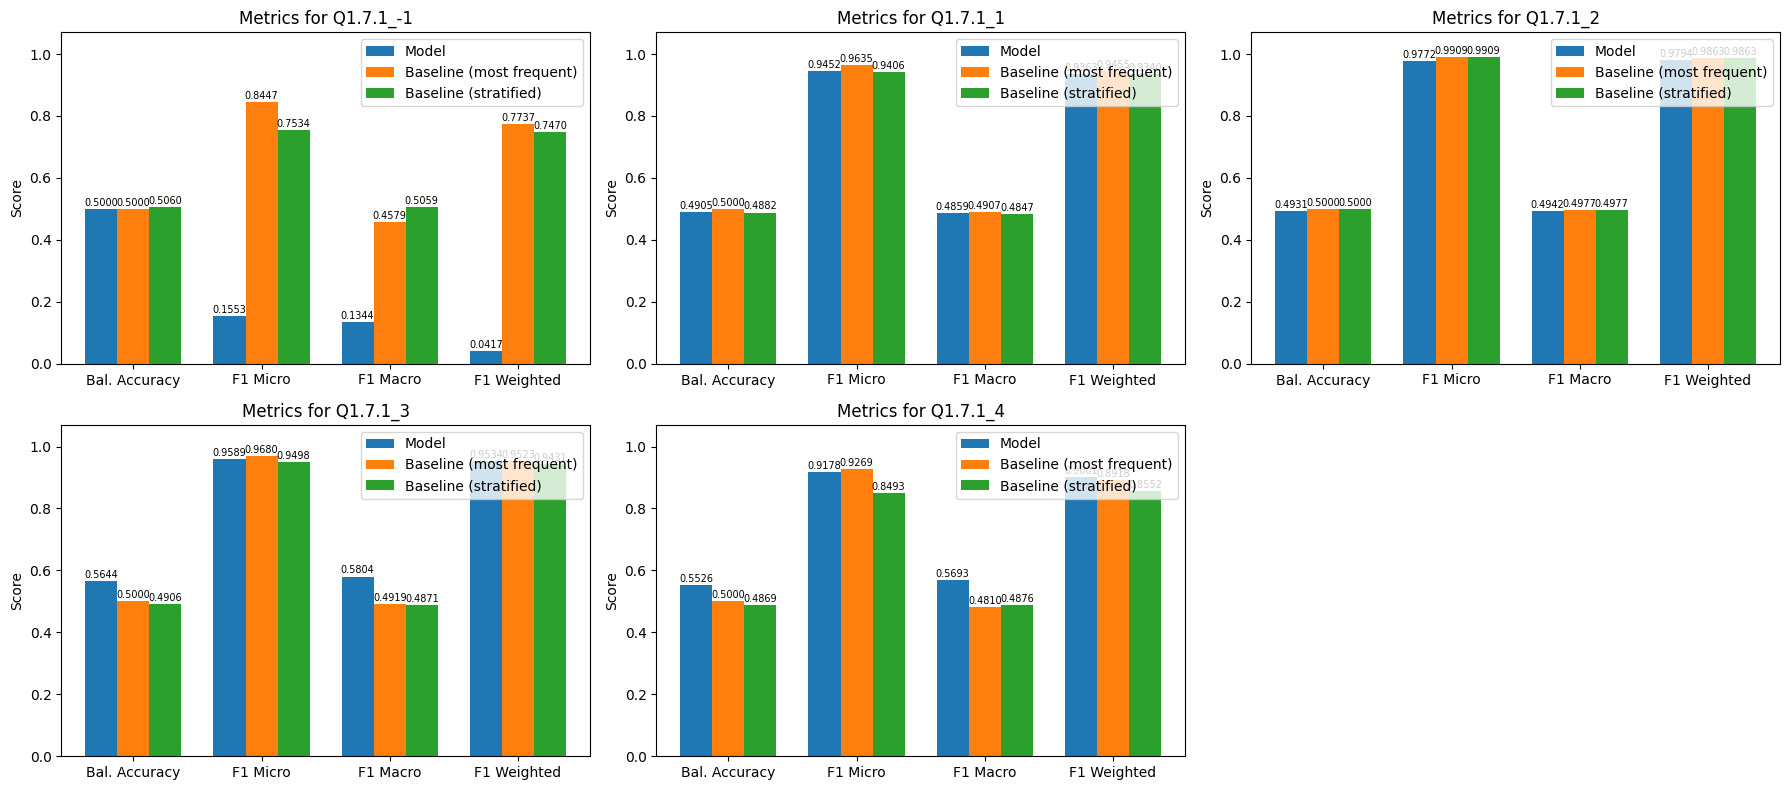

In [127]:
calculate_standard_metrics('Marinella','ChatGPT4AsAnnotator', df_1_7_1)


/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

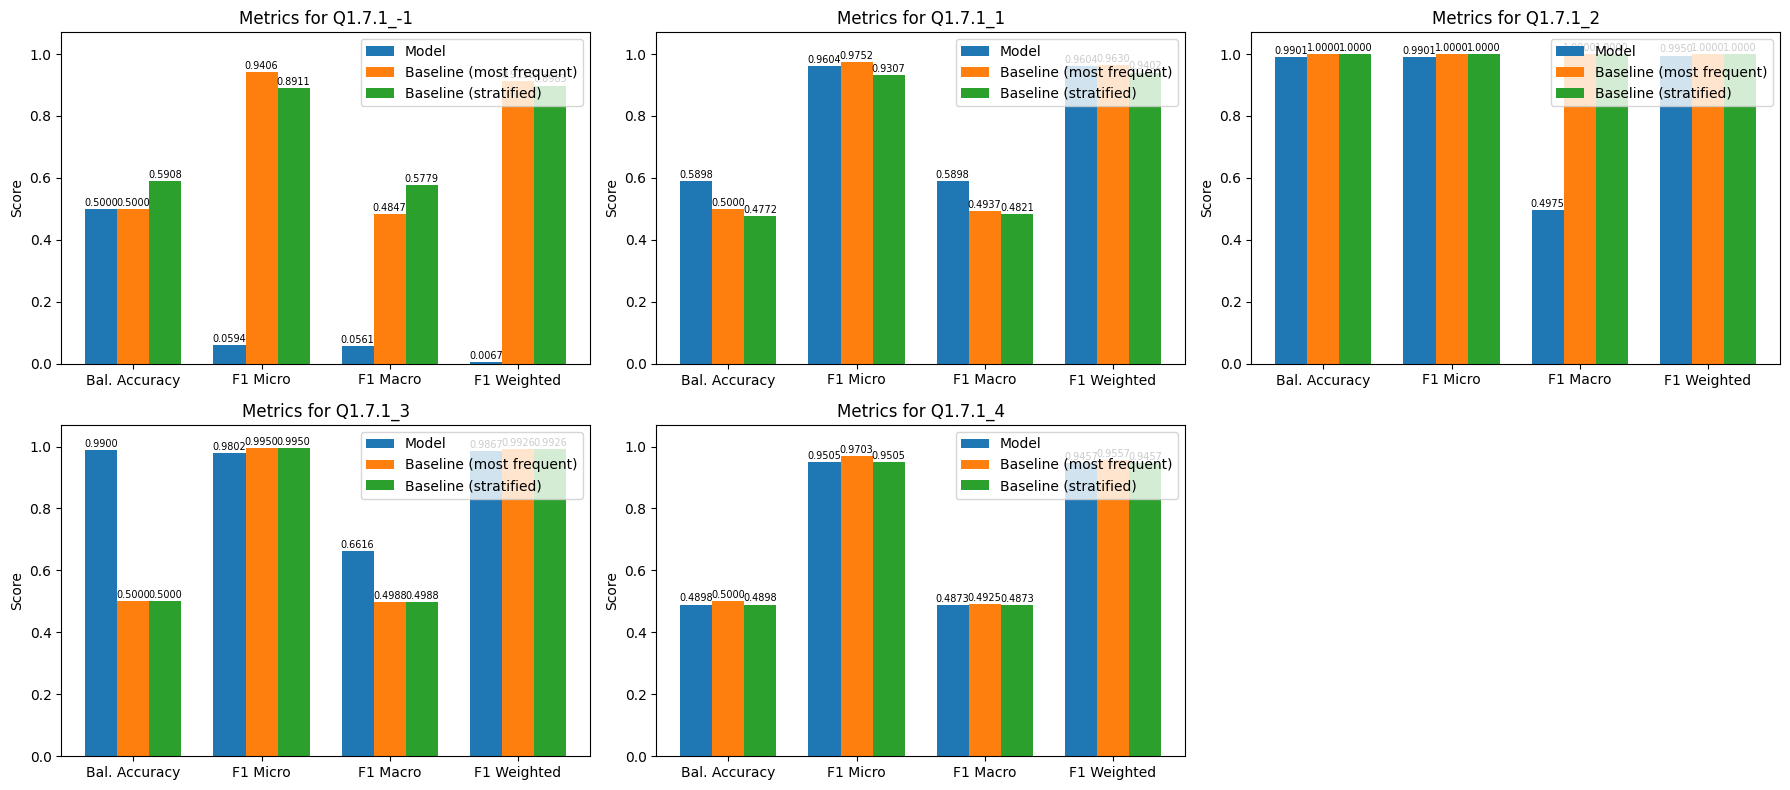

In [128]:
calculate_standard_metrics('Angelo','ChatGPT4AsAnnotator', df_1_7_1)
